In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from grid_world.Gridworld import Gridworld

In [3]:
game = Gridworld(size=4, mode='static')

game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4),
)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9 # discount factor
epsilon = 0.3

In [5]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [6]:
from collections import deque

epochs = 5000
mem_size = 1000 # total size of the experience replay memory
batch_size = 200
replay = deque(maxlen=mem_size) # experience buffer
max_moves = 50
h = 0
losses = []

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0

    while (status == 1):
        mov += 1
        # runs the Q-network to calculate the Q values for all actions
        qval = model(state1)
        qval_ = qval.data.numpy()
        # use epsilon-greedy to select an action
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        # take the action
        action = action_set[action_]
        game.makeMove(action)
        # after making the move, finds the maximum Q value from the
        # new state
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        # adds experience to replay buffer
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model(state2_batch)
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()

            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0

losses = np.array(losses)

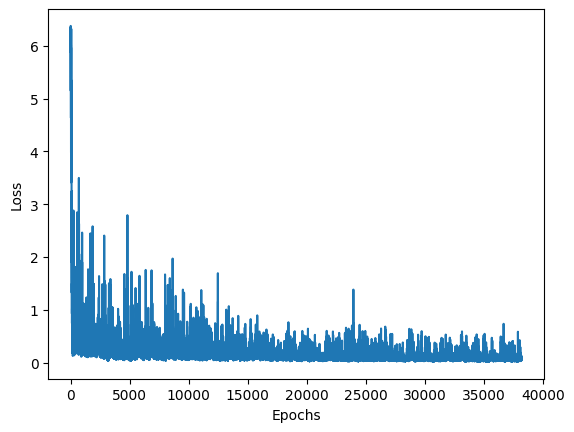

In [7]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(len(losses)), losses)

In [8]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode)
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state = torch.from_numpy(state_).float()

    if display:
        print('Initial State:')
        print(test_game.display())
    
    status = 1
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state = torch.from_numpy(state_).float()

        if display:
            print(test_game.display())

        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print('Game won! Reward %s' % (reward, ))
            else:
                status = 0
                if display:
                    print('Game lost! Reward %s' % (reward, ))

        i += 1
        if (i > 15):
            if display:
                print('Game lost, too many moves')
            break

    win = True if status == 2 else False
    return win


In [9]:
win_count = 0
total_test_games = 1000

for i in range(total_test_games):
    does_win = test_model(model, 'random', False)
    if does_win:
        win_count += 1

print('win rate in random mode: %d/%d' % (win_count, total_test_games))

win rate in random mode: 904/1000
